In [1]:
import ode4
import controller
import ukf
import numpy as np
import os
import pinocchio as pin

from ode4 import quat_to_rpy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm



DEBUG = True

Build a reduced model of the robot. If, when building the model of pinocchio from the Urdf file, we specify pin.JointModelFreeFlyer(), a special joint representing the floating base is added. This floating base adds 6 more degrees of freedom (nv + 6) that includes the translation in three dimensions (x, y, z) and the rotation in three dimensions (roll, pitch, yaw), that added to the 2 degrees of freedom of the wheels make up a total of 8 dofs.

In [2]:
# Initialize the robot model and data 
urdfFile = os.path.join('tiago.urdf')
full_model = pin.buildModelFromUrdf(urdfFile, pin.JointModelFreeFlyer())

# Base-related joints to keep
base_joints_to_keep = [
    'universe',             # Must be kept
    'root_joint',           # Floating base
    'wheel_left_joint',
    'wheel_right_joint',
]

# Get the IDs of all joints to keep and to lock (all joints except the ones to keep)
joints_to_keep_ids = [full_model.getJointId(joint) for joint in base_joints_to_keep if full_model.existJointName(joint)]
joints_to_lock_ids = [jid for jid in range(full_model.njoints) if jid not in joints_to_keep_ids]
# Set initial position for the joints we want to keep; the rest will be locked
initial_joint_config = np.zeros(full_model.nq)

# Build the reduced model
model = pin.buildReducedModel(full_model, joints_to_lock_ids, initial_joint_config)
# Create the data for the reduced model
data = model.createData()

# Check dimensions of the reduced model
print('Reduced model', model)

Reduced model Nb joints = 4 (nq=11,nv=8)
  Joint 0 universe: parent=0
  Joint 1 root_joint: parent=0
  Joint 2 wheel_left_joint: parent=1
  Joint 3 wheel_right_joint: parent=1



In [3]:
# Get the placement (position and orientation) of the root joint
root_joint_placement = data.oMi[model.getJointId('root_joint')]

# Print the placement
print('Base placement:', root_joint_placement)
print('Base rotation:', root_joint_placement.rotation)
print('Base translation:', root_joint_placement.translation)

# Get the pose (position and orientation) of the root joint in (x, y, z, quat) format
root_joint_pose = pin.SE3ToXYZQUAT(root_joint_placement)  

# Print position and orientation
print("\nPosition (x, y, z):", root_joint_pose[:3])
print("Translation (w, x, y, z):", root_joint_pose[3:])

Base placement:   R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

Base rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Base translation: [0. 0. 0.]

Position (x, y, z): [0. 0. 0.]
Translation (w, x, y, z): [0. 0. 0. 1.]


In [4]:
# Initialize robot configuration and velocity
q = pin.neutral(model)
v = pin.utils.zero(model.nv)

# Set the initial configuration and velocity
# x_robot = np.concatenate((quat_to_rpy(q), v))
x_robot = np.array([0, 0, 0, 0, 0])      # [x, y, theta, omegaR, omegaL]

# Initialize vector field matrix
G = np.zeros((model.nv, model.nv))

# Define the controller and UKF objects
contr = controller.Controller()
ukf_est = ukf.UKF()

process:   0%|          | 0/1000 [00:00<?, ?it/s]

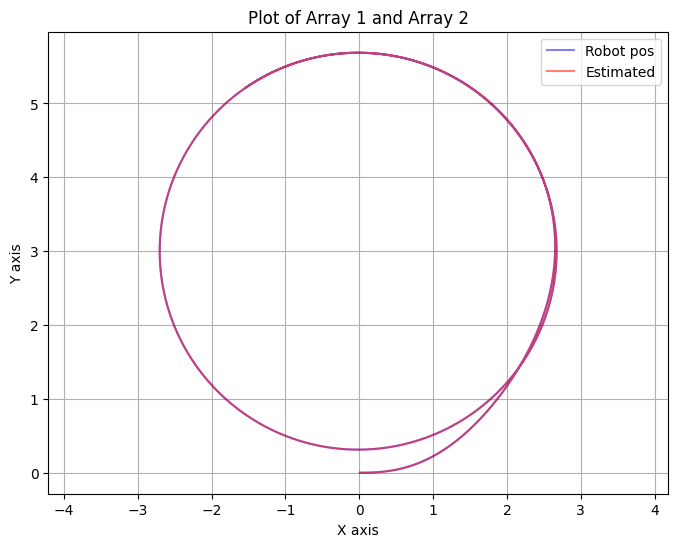

In [5]:
# Time step
dt = 0.1  # Example time step

iL, iR = 0, 0

robot_pos = []
slipp_params = []
est_pos = []
est_params = []

# Loop for the simulation
for i in tqdm(range(600),"process"):
    # Compute all dynamics terms
    pin.computeAllTerms(model, data, q, v)

    # Compute the torques
    tau = contr.command(ukf_est.x)

    if i >= 300:
        iL = 0
        iR = 0
    
    x_robot = ode4.ode4(model, data, x_robot, dt, tau, iL, iR)
    
    # Update the UKF
    ukf_est.read_measures(x_robot,tau)
    ukf_est.compute_sigma_points()
    ukf_est.predict(dt)
    ukf_est.update()

    # Save the robot and estimated positions
    robot_pos.append(x_robot)
    est_pos.append(ukf_est.x)
    slipp_params.append([iL, iR])
    est_params.append([ukf_est.x[5], ukf_est.x[6]])

robot_pos = np.array(robot_pos)
est_pos = np.array(est_pos)



# Extracting x and y coordinates
x1, y1 = robot_pos[:, 0], robot_pos[:, 1]
x2, y2 = est_pos[:, 0], est_pos[:, 1]

slip_L, slip_R = np.array(slipp_params)[:, 0], np.array(slipp_params)[:, 1]
est_L, est_R = np.array(est_params)[:, 0], np.array(est_params)[:, 1]

# Plotting
plt.figure(figsize=(8, 6))  # Set the figure size for better visibility
plt.plot(x1, y1, color='blue', label='Robot pos', alpha=0.5)  # Plot points from array1
plt.plot(x2, y2, color='red', label='Estimated', alpha=0.5)  # Plot points from array2
'''
plt.plot(slip_L, color='green', label='Slippage Left', alpha=0.5) 
plt.plot(slip_R, color='blue', label='Slippage Right', alpha=0.5)
plt.plot(est_L, color='orange', label='Estimated slippage Left', alpha=0.5)  # Plot points from array2
plt.plot(est_R, color='red', label='Estimated slippage Right', alpha=0.5)  # Plot points from array2
'''
# Set labels and title
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('Plot of Array 1 and Array 2')

# Fix axis scale
plt.axis('equal')  # To keep the aspect ratio consistent


plt.legend()  # To add a legend to differentiate the arrays
plt.grid(True)  # Optionally, add a grid for better readability
plt.show()